In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime
import random
import warnings

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

warnings.filterwarnings(action='ignore')

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'
file_name = 'train_data.csv'
test_file_name = 'test_data.csv'

In [3]:
csv_file_path = os.path.join(data_dir, file_name)
df = pd.read_csv(csv_file_path)
df['userID'] = [f'{id:0>4}' for id in df['userID'].values]

# Setting

In [4]:
# id column is ID in aggregation dataset
id_column = 'userID' # one of ['userID', 'userID_testIdHead', 'userId_YMD_testId']
n_folds = 5

# Feature Enginerring

In [5]:
def convert_time(s):
    timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
    return int(timestamp)

def sec2date(s):
    timetuple = time.gmtime(s)
    date = f'{timetuple.tm_year}-{timetuple.tm_mon:0>2}-{timetuple.tm_mday:0>2} {timetuple.tm_hour:0>2}:{timetuple.tm_min:0>2}:{timetuple.tm_sec:0>2}'

    return date

In [6]:
def preprocess(df):
    # YYYY-MM-DD HH:MM:SS -> sec format
    df['TimeSec'] = df['Timestamp'].apply(convert_time)
    print('* success to get time sec format')
    
    # YYYY-MM-DD HH:MM:SS -> YYYY-MM-DD
    df['YMD'] = [date.split()[0] for date in list(df['Timestamp'])]
    print('* success to get YYYY-MM-DD format')
    
    # merge YYYY-MM-DD and testId
    df['YMD_testId'] = df['YMD'] + df['testId']
    print('* success to merge YYYY-MM-DD data and testId data')
    
    # merge userID, YYYY-MM-DD, and testId
    df['userId_YMD_testId'] = df['userID'] + df['YMD'] + df['testId']
    print('* success to merge userID, YYYY-MM-DD data and testId data')
    
    # create testId`s head 
    df['testIdHead'] = [id[1:4] for id in df['testId'].values]
    print('* success to create testId`s head')
    
    # merge userID and testId
    df['userID_testIdHead'] = df['userID'] + df['testIdHead']
    print('* success to merge userID and testIdHead')
    
    return df

In [7]:
def create_additional_df(df, id_column):    
    # create Dataframe for aggregate data of each userID_testIdHead (dataframe idx == userID_testIdHead)
    ID_df = pd.DataFrame(df[id_column].unique(), columns=['ID'])
    ID_df.index = df[id_column].unique()
    print('* success to create dataframe of each id_column')

    # last answerCode of each userID == y
    ID_df['y'] = df.groupby(id_column).apply(lambda x: list(x['answerCode'])[-1])
    print('* success to get y data of each id_column')
    
    # remove last index of each userID == y data is not included in x data
    last_idx = df.groupby(id_column).apply(lambda x: x.index[-1]).values
    df_without_y = df.drop(last_idx)
    print('* success to remove last index of each id_column')
    
    return df_without_y, ID_df

In [8]:
def add_feature(df, df_without_y, ID_df, id_column):
    ID_df['QuesCnt'] = df_without_y.groupby(id_column).size()
    ID_df['CorrectCnt'] = df_without_y.groupby(id_column).sum().answerCode
    ID_df['CorrectPer'] = ID_df['CorrectCnt'] / ID_df['QuesCnt']
    ID_df['CycleCnt'] = df_without_y.groupby(id_column).apply(lambda x: len(x['YMD_testId'].unique()))
    ID_df['QuesPerCycle'] = ID_df['QuesCnt'] / ID_df['CycleCnt']
    maxmin_timestamp_sec = df_without_y.groupby(id_column).apply(lambda x: x['TimeSec'].max()-x['TimeSec'].min())
    ID_df['Max-MinTimestampDay'] = maxmin_timestamp_sec / (60 * 60 * 24)
    
    CyclesPerID = df_without_y.groupby(id_column).apply(lambda x: list(x.groupby(x['YMD_testId']).apply(lambda y: [max(y['TimeSec']), min(y['TimeSec'])])))
    CyclesPerID = CyclesPerID.reset_index()
    MeanCycleIntervalSec = CyclesPerID.groupby(id_column).apply(lambda x: np.mean(np.array(x[0].values[0])[1:][:,1]-np.array(x[0].values[0])[:-1][:,0]) if len(x[0].values[0]) !=1 else 0)
    ID_df['MeanCycleIntervalDay'] = MeanCycleIntervalSec / (60 * 60 * 24)
    
    ID_df['Top10CorrectPer'] = df_without_y.groupby(id_column).apply(lambda x: np.mean(x['answerCode'][-10:]))
    ID_df['Top30CorrectPer'] = df_without_y.groupby(id_column).apply(lambda x: np.mean(x['answerCode'][-30:]))
    ID_df['Top50CorrectPer'] = df_without_y.groupby(id_column).apply(lambda x: np.mean(x['answerCode'][-50:]))
    ID_df['Top100CorrectPer'] = df_without_y.groupby(id_column).apply(lambda x: np.mean(x['answerCode'][-100:]))
    ID_df['LastCycleCorrectPer'] = df.groupby(id_column).apply(lambda x: np.mean(x[x['testId'] == list(x['testId'])[-1]]['answerCode'][:-1]))

    ID_df['MeanTimeDiffinCycle'] = df_without_y.groupby(id_column).apply(lambda x: np.mean(x.groupby('YMD_testId').apply(lambda y: np.mean(np.array(y['TimeSec'])[1:]-np.array(y['TimeSec'])[:-1]) if len(y['TimeSec']) != 1 else 0)))
    
    print('* success to add features')
    
    return ID_df

In [9]:
# create additional columns in df
df = preprocess(df)

* success to get time sec format
* success to get YYYY-MM-DD format
* success to merge YYYY-MM-DD data and testId data
* success to merge userID, YYYY-MM-DD data and testId data
* success to create testId`s head
* success to merge userID and testIdHead


In [10]:
# create df without y column and dataframe for aggregation dataset
df_without_y, ID_df = create_additional_df(df, id_column)

* success to create dataframe of each id_column
* success to get y data of each id_column
* success to remove last index of each id_column


In [11]:
# add features into aggregation dataset
ID_df_fe = add_feature(df, df_without_y, ID_df, id_column)  

* success to add features


In [12]:
# check df
ID_df_fe.iloc[[random.randint(0, len(ID_df_fe)) for _ in range(5)]]

,ID,y,QuesCnt,CorrectCnt,CorrectPer,CycleCnt,QuesPerCycle,Max-MinTimestampDay,MeanCycleIntervalDay,Top10CorrectPer,Top30CorrectPer,Top50CorrectPer,Top100CorrectPer,LastCycleCorrectPer,MeanTimeDiffinCycle
2979,2979,0,667,436,0.653673,114,5.850877,251.009086,2.210475,0.9,0.833333,0.64,0.560000,0.857143,194.753421
0811,0811,0,603,384,0.636816,83,7.265060,347.217095,4.209918,0.4,0.433333,0.52,0.530000,0.571429,368.252691
3808,3808,0,130,67,0.515385,22,5.909091,85.945521,4.090495,0.6,0.366667,0.32,0.480000,0.571429,36.675216
5092,5092,1,95,78,0.821053,16,5.937500,243.207812,16.210508,0.9,0.933333,0.90,0.821053,1.000000,59.241518
3721,3721,1,259,199,0.768340,41,6.317073,233.239641,5.817503,0.9,0.933333,0.94,0.890000,1.000000,211.389024


# Training

In [13]:
def kfold_training(ID_df_fe, n_features, n_splits):
    # define X, y
    X = ID_df_fe.drop(['ID', 'y'], axis=1)
    X = X.values
    y = ID_df_fe['y'].values

    # feature selection
    lgbm_wrapper = LGBMClassifier(n_estimators=400)
    selector = RFE(lgbm_wrapper, n_features_to_select=n_features, step=1)
    selector = selector.fit(X, y)

    # select features
    X = X[:,selector.support_]

    fold_acc = []
    fold_auc = []
    models = []
    # split train, valid dataset
    skf = StratifiedKFold(n_splits=n_splits)
    for train_index, valid_index in skf.split(X, y):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid)

        # training
        model = lgb.train(
                            {'objective': 'binary'}, 
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            verbose_eval=100,
                            num_boost_round=500,
                            early_stopping_rounds=100
                        )
        models.append(model)
        
        preds = model.predict(X_valid)
        fold_acc.append(accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0)))
        fold_auc.append(roc_auc_score(y_valid, preds))
    
    return models, selector, np.mean(fold_acc), np.mean(fold_auc)

In [14]:
# search best number of features
best_auc = 0
best_n_feature = 0
n_columns = len(ID_df_fe.drop(['ID', 'y'], axis=1).columns)

for n_feature in range(1, n_columns+1):
    _, _, _, auc = kfold_training(ID_df_fe, n_feature, n_folds)
    if best_auc < auc:
        best_auc = auc
        best_n_feature = n_feature
    
    print(f'* searching best number of features [{n_feature}/{n_columns}]', end='\r')
    
print(f'* best number of features : {best_n_feature}                ')

* best number of features : 12                


In [15]:
# training with best number of features
models, selector, acc, auc = kfold_training(ID_df_fe, best_n_feature, n_folds)
print(f'* Valid ACC : {acc:.4f}, Valid AUC : {auc:.4f}')

* Valid ACC : 0.6714, Valid AUC : 0.7312


column_0 : QuesCnt
column_1 : CorrectCnt
column_2 : CorrectPer
column_3 : CycleCnt
column_4 : QuesPerCycle
column_5 : Max-MinTimestampDay
column_6 : MeanCycleIntervalDay
column_7 : Top10CorrectPer
column_8 : Top30CorrectPer
column_9 : Top50CorrectPer
column_10 : Top100CorrectPer
column_11 : LastCycleCorrectPer
column_12 : MeanTimeDiffinCycle


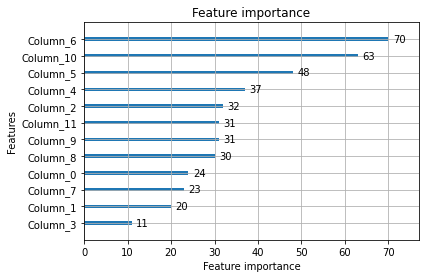

In [16]:
# check feature importance
lgb.plot_importance(models[1])

for idx, col in enumerate(ID_df_fe.drop(['ID', 'y'], axis=1).columns):
    print(f'column_{idx} : {col}')

# Inference

In [17]:
# load test dataset
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)
test_df['userID'] = [f'{id:0>4}' for id in test_df['userID'].values]

In [18]:
# create additional columns in df
test_df = preprocess(test_df)

* success to get time sec format
* success to get YYYY-MM-DD format
* success to merge YYYY-MM-DD data and testId data
* success to merge userID, YYYY-MM-DD data and testId data
* success to create testId`s head
* success to merge userID and testIdHead


In [19]:
# create df without y column and dataframe for aggregation dataset
test_df_without_y, test_ID_df = create_additional_df(test_df, id_column)

* success to create dataframe of each id_column
* success to get y data of each id_column
* success to remove last index of each id_column


In [20]:
# pick dataset that should be predicted
test_ID_df = test_ID_df[test_ID_df['y'] == -1] 

In [21]:
# add features into aggregation dataset
test_ID_df_fe = add_feature(test_df, test_df_without_y, test_ID_df, id_column)  

* success to add features


In [22]:
# feature selection
X_test = test_ID_df_fe.drop(['ID', 'y'], axis=1)
X_test = X_test.values
X_test = X_test[:,selector.support_]

In [23]:
# prediction
total_preds = 0
for k in range(n_folds):
    total_preds += models[k].predict(X_test)
total_preds /= n_folds

In [24]:
# write submission
output_dir = 'output/'
write_path = os.path.join(output_dir, f"lgbm_{id_column}_k{n_folds}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/lgbm_userID_k5.csv
